## Pacotes

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## Kalman Fusion

In [16]:
%run 3-kalman.ipynb

## Função Auxiliares

In [17]:
def generate_data(n_samples=200, noise_model=0.05, noise_feats=None, seed=42):
    """
    Gera série sintética:
      - ground truth suave (senoide normalizada em [0,1])
      - saída GNN ruidosa (probabilidades)
      - heurísticas ruidosas (etx, delay, busy)
    """
    np.random.seed(seed)
    t = np.linspace(0, 4*np.pi, n_samples)
    ground_truth = 0.5 + 0.5 * np.sin(t)

    # modelo (gnn) ruidoso
    gnn = np.clip(ground_truth + np.random.normal(0, noise_model, n_samples), 0, 1)

    # converte modelo para dict de classes (baixa, média, alta)
    gnn_dicts = []
    for p in gnn:
        gnn_dicts.append({
            "baixa": 1-p if p < 0.33 else 0,
            "media": 1-p if 0.33 <= p < 0.66 else 0,
            "alta": p if p >= 0.66 else 0
        })

    # heurísticas (exemplo: ETX, delay, busy)
    feats_all = []
    if noise_feats is None:
        noise_feats = {"etx":0.08, "delay":0.05, "busy":0.07}

    for val in ground_truth:
        feats = {}
        for k, sigma in noise_feats.items():
            feats[k] = np.clip(val + np.random.normal(0, sigma), 0, 1)
        feats_all.append(feats)

    return ground_truth, gnn_dicts, feats_all

def run_kalman(gnn_dicts, feats_all, Q=0.01, R_model=0.1, R_feats=None, adapt_R=False):
    """
    Roda a fusão Kalman ao longo da série temporal.
    """
    kf = KalmanFusion(Q=Q, R_model=R_model, R_feats=R_feats, adapt_R=adapt_R)
    fused = []
    for pd, fd in zip(gnn_dicts, feats_all):
        fused.append(kf.update(pd, fd))
    return np.array(fused)

## Benchmark 1: Robustez ao Ruído

In [18]:
def benchmark_noise(noise_levels, n_samples=200):
    results = {"noise": [], "mae_model": [], "mae_feats": [], "mae_fused": []}
    for sigma in noise_levels:
        gt, gnn_dicts, feats_all = generate_data(n_samples=n_samples,
                                                 noise_model=sigma,
                                                 noise_feats={"etx":sigma, "delay":sigma, "busy":sigma})
        # modelo sozinho
        model_scores = np.array([KalmanFusion()._probs_to_score(d) for d in gnn_dicts])
        mae_model = np.mean(np.abs(model_scores - gt))

        # heurísticas (média simples)
        feats_scores = np.array([np.mean(list(fd.values())) for fd in feats_all])
        mae_feats = np.mean(np.abs(feats_scores - gt))

        # fusão Kalman
        fused_scores = run_kalman(gnn_dicts, feats_all, R_model=sigma, R_feats={"etx":sigma, "delay":sigma, "busy":sigma})
        mae_fused = np.mean(np.abs(fused_scores - gt))

        # salva
        results["noise"].append(sigma)
        results["mae_model"].append(mae_model)
        results["mae_feats"].append(mae_feats)
        results["mae_fused"].append(mae_fused)
    return results

def plot_benchmark_noise(results):
    plt.figure(figsize=(8,6))
    plt.plot(results["noise"], results["mae_model"], label="Modelo (GNN)")
    plt.plot(results["noise"], results["mae_feats"], label="Heurísticas (média)")
    plt.plot(results["noise"], results["mae_fused"], label="Fusão Kalman", linewidth=2)
    plt.xlabel("Nível de Ruído (σ)")
    plt.ylabel("Erro Médio Absoluto (MAE)")
    plt.title("Benchmark 1 - Robustez ao Ruído")
    plt.legend()
    plt.grid(True)
    plt.show()

## Benchmark 2: Robustez Temporal

In [19]:
def benchmark_temporal(n_samples=200, noise_model=0.1, noise_feats=None):
    gt, gnn_dicts, feats_all = generate_data(n_samples=n_samples,
                                             noise_model=noise_model,
                                             noise_feats=noise_feats)

    model_scores = np.array([KalmanFusion()._probs_to_score(d) for d in gnn_dicts])
    feats_scores = np.array([np.mean(list(fd.values())) for fd in feats_all])
    fused_scores = run_kalman(gnn_dicts, feats_all, R_model=noise_model, R_feats=noise_feats)

    return gt, model_scores, feats_scores, fused_scores

def plot_benchmark_temporal(gt, model_scores, feats_scores, fused_scores):
    plt.figure(figsize=(12,6))
    plt.plot(gt, label="Ground Truth", linewidth=2)
    plt.plot(model_scores, label="Modelo (GNN)", alpha=0.7)
    plt.plot(feats_scores, label="Heurísticas (média)", alpha=0.7)
    plt.plot(fused_scores, label="Fusão Kalman", linewidth=2)
    plt.xlabel("Tempo (amostras)")
    plt.ylabel("Score [0,1]")
    plt.title("Benchmark 2 - Robustez Temporal")
    plt.legend()
    plt.grid(True)
    plt.show()

## Execução

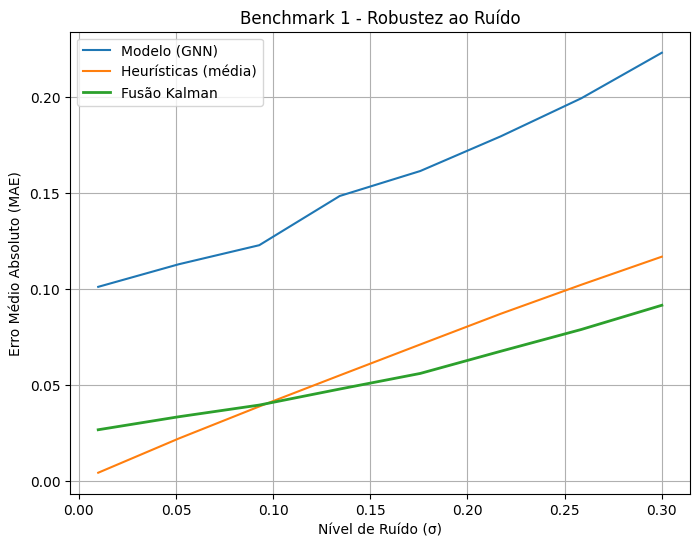

In [20]:
# Benchmark 1
noise_levels = np.linspace(0.01, 0.3, 8)
results_noise = benchmark_noise(noise_levels)
plot_benchmark_noise(results_noise)

### Benchmark 1 – Robustez ao Ruído

- Eixo X: nível de ruído (σ), ou seja, quanto mais à direita, mais distorcidas estão as medições do modelo e das heurísticas.
- Eixo Y: erro médio absoluto (MAE) em relação ao ground truth.

#### Linhas:

- Azul (Modelo GNN) → sofre muito com o ruído, o erro cresce rápido.
- Laranja (Heurísticas, média simples) → mais estáveis que o GNN, mas ainda degradam com ruído.
- Verde (Fusão Kalman) → mantém o erro sempre menor que os outros, mostrando que a fusão é mais robusta a incertezas.

#### Conslusão:

Mesmo quando o ambiente está ruidoso, o Kalman consegue integrar as fontes e manter a estimativa mais próxima do valor real.

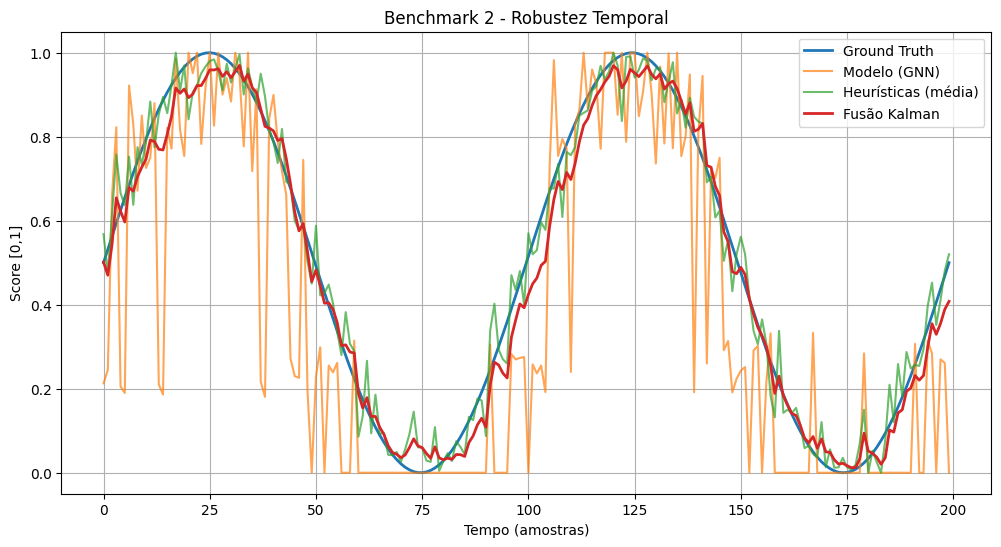

In [21]:
# Benchmark 2
gt, model_scores, feats_scores, fused_scores = benchmark_temporal(noise_model=0.15, noise_feats={"etx":0.08,"delay":0.12,"busy":0.1})
plot_benchmark_temporal(gt, model_scores, feats_scores, fused_scores)

### Benchmark 2 – Robustez Temporal

- Eixo X: tempo (amostras).
- Eixo Y: score [0,1] (0 = ótimo, 1 = ruim).

#### Linhas:

- Azul (Ground Truth) → a curva senoide ideal (o “mundo real”).
- Verde (Modelo GNN) → segue o padrão, mas com bastante variação (ruído).
- Larnja (Heurísticas) → extremamente instáveis (saltos bruscos).
- Vermelho (Fusão Kalman) → acompanha o ground truth de forma suave e fiel, eliminando picos falsos.

#### Conslusão:

O Kalman age como um filtro temporal, reduzindo a variabilidade e aproximando a saída da realidade ao longo do tempo